해당 커널은 아래 커널을 참고하여 공부한 내용입니다. <br>
https://www.kaggle.com/gaborfodor/from-eda-to-the-top-lb-0-367

```
이번 대회에서 카글은 뉴욕에서의 택시 여행의 총 운행 기간을 예측하는 모델을 만드는 데 도전하고 있다.<br>
당신의 기본 데이터 세트는 픽업 시간, 지리 좌표, 승객 수 및 기타 여러 변수가 포함된다.

- id - 각 운행에 대한 id
- vendor_id - 운행기록 제공자(회사)에 대한 id
- pickup_datetime - date and time when the meter was engaged
- dropoff_datetime - date and time when the meter was disengaged
- passenger_count - the number of passengers in the vehicle
- pickup_longitude - the longitude where the meter was engaged
- pickup_latitude - the latitude where the meter was engaged
- dropoff_longitude - the longitude where the meter was disengaged
- dropoff_latitude - the latitude where the meter was disengaged
- store_and_fwd_flag 
    - whether the trip record was held in vehicle memory before sending <br>
      to the vendor because the vehicle did not have a connection to the server 
    - Y=store and forward; N=not a store and forward trip
- trip_duration - duration of the trip in seconds (운행기간 단위는 초)
```

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.csv', 'sample_submission.csv', 'test.csv']


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# engine='c', parse_dates, infer_datetime_format
train = pd.read_csv('../input/train.csv') 
test = pd.read_csv('../input/test.csv')
print(train.shape)
print(test.shape)

(1458644, 11)
(625134, 9)


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [5]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [6]:
print(train.columns)
print(test.columns) # dropoff_datetime, trip_duration 칼럼이 없다.

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')
Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag'],
      dtype='object')


In [7]:
print(np.setdiff1d(train.columns, test.columns))

['dropoff_datetime' 'trip_duration']


```
# 전처리
- 결측값은 없는가? 
    - 결측값없음. (추후 파생특성에서 결측값 발생시?)
- id를 제외한 문자열은 없는가? 
    - store_and_fwd_flag 문자열은 라벨인코딩한다.(Y/N)
    - pickup_datetime, dropoff_datetime은 datetime형식으로 변환한다.
- 경도/위도의 값이 과도하게 큰 값은 없는가? 처리하지않아도 문제없는가?
    - 그래프 표시할경우 평균값에 +-0.2를 한다.
    - city_long_border = (-74.03, -73.75)
    - city_lat_border = (40.63, 40.85)
- passenger_count가 0명 값은 ? 
    - 승객이 타지않은 상태의 정보, train,test 모두 존재, 그냥 나둔다. 
- trip_duration 과도하게 큰 값은 없는가? 
    - 삭제한다.
```

In [8]:
print('train내 id중복없음 :', train['id'].nunique() == train.shape[0])
# id의 유니크 개수와 행개수가 동일하면 id중복은 없다는 것.
print('train과 test의 id중복없음 :', len(np.intersect1d(train.id.values, test.id.values)) == 0)
# train과 test의 id가 중복없음.

train내 id중복없음 : True
train과 test의 id중복없음 : True


In [9]:
print(train.count().min() == train.shape[0])
print(test.count().min() == test.shape[0])
# missing value없음.

True
True


In [10]:
print(train.store_and_fwd_flag.unique())
print(test.store_and_fwd_flag.unique())
print(train['vendor_id'].unique())
print(test['vendor_id'].unique())
# 해당 칼럼은 값이 2개

['N' 'Y']
['N' 'Y']
[2 1]
[1 2]


In [11]:
train['store_and_fwd_flag'] = 1 * (train.store_and_fwd_flag.values == 'Y')
test['store_and_fwd_flag'] = 1 * (test.store_and_fwd_flag.values == 'Y')
# 문자 라벨 인코딩 Y는 1, N은 0

In [12]:
train['pickup_datetime']= pd.to_datetime(train['pickup_datetime'])
train['dropoff_datetime']= pd.to_datetime(train['dropoff_datetime'])
test['pickup_datetime']= pd.to_datetime(test['pickup_datetime'])
# 시간변수를 문자열에서 datetime으로 변환, csv에서 불러올때 바로 변환하는 방법도 있다.

In [13]:
train['pickup_date']= train['pickup_datetime'].dt.date
test['pickup_date']= test['pickup_datetime'].dt.date
# 시,분,초을 제외한 time추출 (2016-05-01)

In [14]:
# 지역정보, 경도/위도에 대해 살펴본다.
train[['pickup_longitude','dropoff_longitude', 'pickup_latitude', 'dropoff_latitude']].describe()

,pickup_longitude,dropoff_longitude,pickup_latitude,dropoff_latitude
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,-7.397349e+01,-7.397342e+01,4.075092e+01,4.075180e+01
std,7.090186e-02,7.064327e-02,3.288119e-02,3.589056e-02
min,-1.219333e+02,-1.219333e+02,3.435970e+01,3.218114e+01
25%,-7.399187e+01,-7.399133e+01,4.073735e+01,4.073588e+01
50%,-7.398174e+01,-7.397975e+01,4.075410e+01,4.075452e+01
75%,-7.396733e+01,-7.396301e+01,4.076836e+01,4.076981e+01
max,-6.133553e+01,-6.133553e+01,5.188108e+01,4.392103e+01


In [15]:
train['idx']= train.index

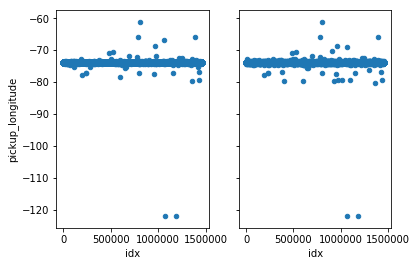

In [16]:
# longitude 값의 분포는?
fig, ax = plt.subplots(ncols=2, sharey=True)
train.plot.scatter(x='idx', y='pickup_longitude', ax=ax[0])
train.plot.scatter(x='idx', y='dropoff_longitude', ax=ax[1])

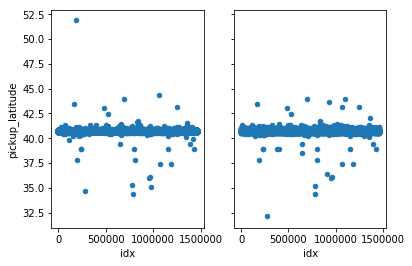

In [17]:
# latitude 값의 분포는?
fig, ax = plt.subplots(ncols=2, sharey=True)
train.plot.scatter(x='idx', y='pickup_latitude', ax=ax[0])
train.plot.scatter(x='idx', y='dropoff_latitude', ax=ax[1])

In [18]:
# 위의 그래프를 확인했을때
#  -80 < long < -60
#  32 < lat < 45
# 평균치 73.97 , 40.75 +-0.2 (그래프 확인시)
long_m= -73.97
lat_m= 40.75
city_long_border = (long_m-0.2, long_m+0.2)
city_lat_border = (lat_m-0.2, lat_m+0.2) 
# city_long_border = (-74.03, -73.75)
# city_lat_border = (40.63, 40.85) 

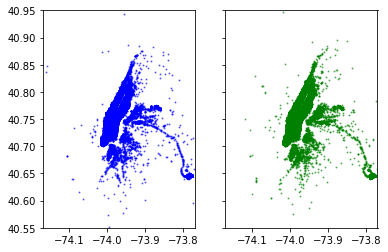

In [19]:
N = 100000
fig,ax= plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].scatter(train['pickup_longitude'].values[:N], train['pickup_latitude'].values[:N], 
              color='b', s=1, label='train', alpha=0.5)
ax[1].scatter(test['pickup_longitude'].values[:N], test['pickup_latitude'].values[:N], 
              color='g', s=1, label='train', alpha=0.5)

plt.xlim(city_long_border) # long
plt.ylim(city_lat_border) # lat
plt.show()


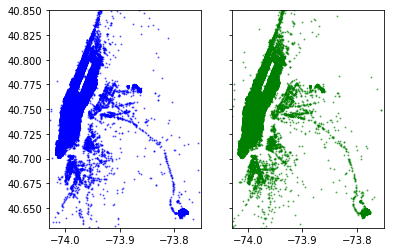

In [20]:
# 다시 조정
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85) 

N = 100000
fig,ax= plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].scatter(train['pickup_longitude'].values[:N], train['pickup_latitude'].values[:N], 
              color='b', s=1, label='train', alpha=0.5)
ax[1].scatter(test['pickup_longitude'].values[:N], test['pickup_latitude'].values[:N], 
              color='g', s=1, label='train', alpha=0.5)

plt.xlim(city_long_border) # long
plt.ylim(city_lat_border) # lat
plt.show()

1
979.5227777777778


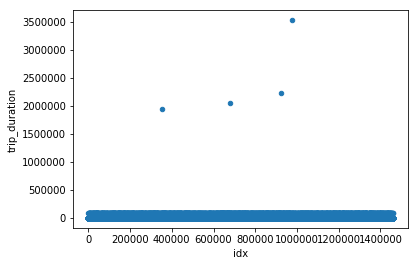

In [21]:
print(train['trip_duration'].min())
print(train['trip_duration'].max() / 3600)
train.plot.scatter(x='idx', y='trip_duration')
# 1초??, 979시간?? 아웃밸류임.
# Fortunately the evaluation metric is RMSLE and not RMSE . 
# Outliers will cause less trouble. We could logtransform our target label and use RMSE during training.

In [22]:
# 운행시간 48시간 이상 삭제 
Idx = train[train['trip_duration'] > 48*3600].index
train= train.drop(Idx, axis=0)
# train= train[train['trip_duration'] < 48*3600]

# Feature Extraction
- Extract 59 useful feature
- 기존 feature 7개
     1. ~~id~~
     - vendor_id
     - ~~pickup_datetime~~
     - passenger_count
     - pickup_longitude
     - pickup_latitude
     - dropoff_longitude
     - dropoff_latitude
     - store_and_fwd_flag
     

- 추가 feature  
    1. 승차/하차 장소,지역 (8)
        - 추가: 승차/하차 PCA변환_경도/위도 (4)
        - 추가: 승차/하차 클러스터링 경도/위도 (4)   
        - 추가: ~~승차/하차 경도/위도 bin~~ 
    - 운행거리 (6)
        - 추가: 하버사인, 더미, 베어링, PCA연산 (4)
        - 추가: 센터경도/위도 (2)
        - 추가: ~~센터경도/위도 bin~~
    - 승차시간 (5)
        - 추가: 주일, 주년, ~~일~~, 시, 분, 초, 주시
        - 추가: ~~초bin~~    
    - 운행속도 (0) -> 운행거리 / 운행시간
        - 추가: ~~하버사인 평속, 더미 평속, 로그운행시간~~  
    - 장소와 시간에 따른 평균운행속도 (23)
        - 추가: 시, 일, 초bin, 주시, 클러스터승차/하차에 따른 하버사인 평속 (6) 
        - 추가: 위 동일,에 따른 더미 평속 (6)
        - 추가: 위 동일,에 따른 운행 시간 (6)
        - 추가: 센터경도+위도, 시+센터경도+위도, 시+클러스터승차, 시+클러스터하차 (4)
        - 추가: 클러스터승차+클러스터하차 하버사인 평속 (1)
    - 운행횟수 (7)
        - 추가: 위 동일, id횟수 (5)
        - 추가: ~~pickup_datetime_group~~
        - 추가: dropoff_cluster_count
        - 추가: pikup_cluster_count
    - OSMR 피쳐, 외부데이타 (3)
        - 추가: 총 거리, 총 운행시간, 스텝수 (???)

In [23]:
7+8+6+5+23+7+3

59

In [24]:
# 위도/경도를 PCA값으로 변환 (2차원->2차원)
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import warnings

warnings.filterwarnings('ignore')

In [25]:
coords= np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
          train[['dropoff_latitude', 'dropoff_longitude']].values,
          test[['pickup_latitude', 'pickup_longitude']].values,
          test[['dropoff_latitude', 'dropoff_longitude']].values         
         ))

In [26]:
coords.shape # 수직으로 쌓다. 행방향으로 쌓았음. 

(4167548, 2)

In [27]:
pca = PCA().fit(coords)
# PCA 주성분 분석
# (1) 특성추출: 특성들이 통계적으로 상관관계가 없도록 데이터셋을 회전하는 기술 (2차원에서 2차원 또는 1차원으로 변환)
# (2) 차원축소 : 고차원의 데이터셋 시각화 (10차원에서 3차원~1차원으로 변환)

In [28]:
# PCA 지역정보
# 기존 4개 칼럼 -> PCA로 변환된 칼럼 4개
train['pickup_pca0'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 0]
train['pickup_pca1'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 1]
train['dropoff_pca0'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
train['dropoff_pca1'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 1]
test['pickup_pca0'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 0]
test['pickup_pca1'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 1]
test['dropoff_pca0'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
test['dropoff_pca1'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 1]

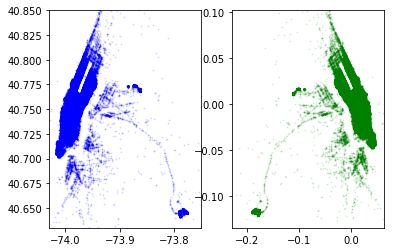

In [29]:
fig, ax = plt.subplots(ncols=2)
ax[0].scatter(train['pickup_longitude'].values[:N], train['pickup_latitude'].values[:N],
              color='blue', s=1, alpha=0.1)
ax[1].scatter(train['pickup_pca0'].values[:N], train['pickup_pca1'].values[:N],
              color='green', s=1, alpha=0.1)
ax[0].set_xlim(city_long_border)
ax[0].set_ylim(city_lat_border)
pca_borders = pca.transform([[x, y] for x in city_lat_border for y in city_long_border])
ax[1].set_xlim(pca_borders[:, 0].min(), pca_borders[:, 0].max())
ax[1].set_ylim(pca_borders[:, 1].min(), pca_borders[:, 1].max())
plt.show()

In [30]:
# 클러스터링 지역정보, 2가지 컬럼
sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])

train.loc[:, 'pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
test.loc[:, 'pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

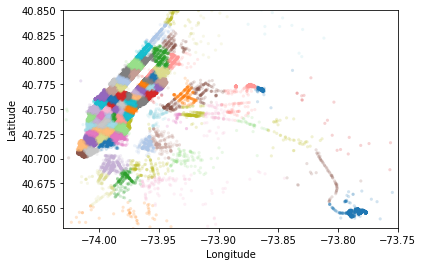

In [31]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.pickup_longitude.values[:N], train.pickup_latitude.values[:N], s=10, lw=0,
           c=train.pickup_cluster[:N].values, cmap='tab20', alpha=0.2)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

In [32]:
# 경도/위도 bin, 센터 경도/위도 bin, 지역정보 4가지 (추후 입력특성으로 사용하지 않음.), long경도, lat위도
train.loc[:, 'pickup_lat_bin'] = np.round(train['pickup_latitude'], 2)
train.loc[:, 'pickup_long_bin'] = np.round(train['pickup_longitude'], 2)
test.loc[:, 'pickup_lat_bin'] = np.round(test['pickup_latitude'], 2)
test.loc[:, 'pickup_long_bin'] = np.round(test['pickup_longitude'], 2)

In [33]:
# 거리정보를 구해보자.
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [34]:
# 거리 4가지, train
train.loc[:, 'distance_haversine'] = haversine_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:, 'distance_dummy_manhattan'] = dummy_manhattan_distance(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:, 'direction'] = bearing_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:, 'pca_manhattan'] = np.abs(train['dropoff_pca1'] - train['pickup_pca1']) + np.abs(train['dropoff_pca0'] - train['pickup_pca0'])

In [35]:
# 거리 4가지, test
test.loc[:, 'distance_haversine'] = haversine_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:, 'distance_dummy_manhattan'] = dummy_manhattan_distance(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:, 'direction'] = bearing_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:, 'pca_manhattan'] = np.abs(test['dropoff_pca1'] - test['pickup_pca1']) + np.abs(test['dropoff_pca0'] - test['pickup_pca0'])

In [36]:
# 센터 거리정보 (승차/하차위치의 센터, 승차/하차위치의 센터bin)
# 4가지 컬럼
train.loc[:, 'center_latitude'] = (train['pickup_latitude'].values + train['dropoff_latitude'].values) / 2
train.loc[:, 'center_longitude'] = (train['pickup_longitude'].values + train['dropoff_longitude'].values) / 2
test.loc[:, 'center_latitude'] = (test['pickup_latitude'].values + test['dropoff_latitude'].values) / 2
test.loc[:, 'center_longitude'] = (test['pickup_longitude'].values + test['dropoff_longitude'].values) / 2

train.loc[:, 'center_lat_bin'] = np.round(train['center_latitude'], 2)
train.loc[:, 'center_long_bin'] = np.round(train['center_longitude'], 2)
test.loc[:, 'center_lat_bin'] = np.round(test['center_latitude'], 2)
test.loc[:, 'center_long_bin'] = np.round(test['center_longitude'], 2)

In [37]:
# 시간 (총 6가지)
# 이번주 몇번째날?, 
# 이번년도 몇번째주?,
# 몇시, 몇분, 몇번째초, 이번주 몇번째시, 몇번째초bin?

train.loc[:, 'pickup_weekday'] = train['pickup_datetime'].dt.weekday # 해당 주에 몇번째 일
train.loc[:, 'pickup_hour_weekofyear'] = train['pickup_datetime'].dt.weekofyear # 해당 년에 몇번째 주
train.loc[:, 'pickup_hour'] = train['pickup_datetime'].dt.hour
train.loc[:, 'pickup_minute'] = train['pickup_datetime'].dt.minute
train.loc[:, 'pickup_dt'] = (train['pickup_datetime'] - train['pickup_datetime'].min()).dt.total_seconds() # 전체 시간을 초로 변환
train.loc[:, 'pickup_week_hour'] = train['pickup_weekday'] * 24 + train['pickup_hour']
train.loc[:, 'pickup_dt_bin'] = (train['pickup_dt'] // (3 * 3600)) # dt 초를 3시간 단위로 범주화

test.loc[:, 'pickup_weekday'] = test['pickup_datetime'].dt.weekday
test.loc[:, 'pickup_hour_weekofyear'] = test['pickup_datetime'].dt.weekofyear
test.loc[:, 'pickup_hour'] = test['pickup_datetime'].dt.hour
test.loc[:, 'pickup_minute'] = test['pickup_datetime'].dt.minute
test.loc[:, 'pickup_dt'] = (test['pickup_datetime'] - train['pickup_datetime'].min()).dt.total_seconds()
test.loc[:, 'pickup_week_hour'] = test['pickup_weekday'] * 24 + test['pickup_hour']
test.loc[:, 'pickup_dt_bin'] = (test['pickup_dt'] // (3 * 3600)) 


In [38]:
train[['pickup_datetime','pickup_hour','pickup_minute','pickup_dt', 
       'pickup_weekday', 'pickup_hour_weekofyear','pickup_week_hour', 'pickup_dt_bin']].head()

,pickup_datetime,pickup_hour,pickup_minute,pickup_dt,pickup_weekday,pickup_hour_weekofyear,pickup_week_hour,pickup_dt_bin
0,2016-03-14 17:24:55,17,24,6369878.0,0,11,17,589.0
1,2016-06-12 00:43:35,0,43,14085798.0,6,23,144,1304.0
2,2016-01-19 11:35:24,11,35,1596907.0,1,3,35,147.0
3,2016-04-06 19:32:31,19,32,8364734.0,2,14,67,774.0
4,2016-03-26 13:30:55,13,30,7392638.0,5,12,133,684.0


In [39]:
# 거리(km)/운행시간(s) = 속도(km/s)
# 속도 3가지
train.loc[:, 'avg_speed_h'] = 1000 * train['distance_haversine'] / train['trip_duration']
train.loc[:, 'avg_speed_m'] = 1000 * train['distance_dummy_manhattan'] / train['trip_duration']
train['log_trip_duration'] = np.log(train['trip_duration'].values + 1)

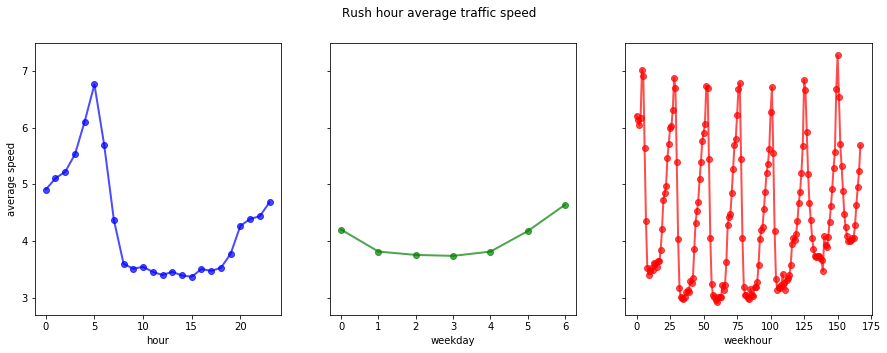

In [40]:
# 시간대에 따른 속도변화 시각화
fig, ax = plt.subplots(ncols=3, sharey=True, figsize=(15,5))
ax[0].plot(train.groupby('pickup_hour').mean()['avg_speed_h'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(train.groupby('pickup_weekday').mean()['avg_speed_h'], 'go-', lw=2, alpha=0.7)
ax[2].plot(train.groupby('pickup_week_hour').mean()['avg_speed_h'], 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('hour')
ax[1].set_xlabel('weekday')
ax[2].set_xlabel('weekhour')
ax[0].set_ylabel('average speed')
fig.suptitle('Rush hour average traffic speed')
plt.show()

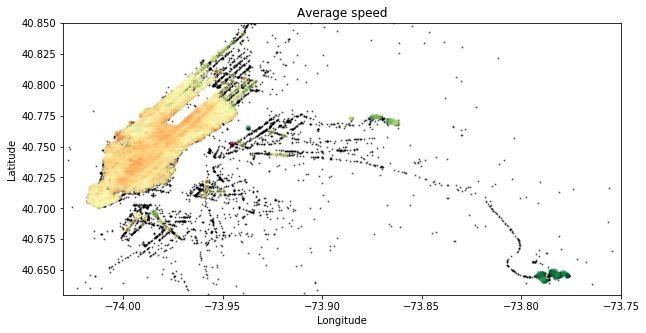

In [41]:
# 지역범위에 따른 속도변화 시각화

train.loc[:, 'pickup_lat_bin'] = np.round(train['pickup_latitude'], 3)
train.loc[:, 'pickup_long_bin'] = np.round(train['pickup_longitude'], 3)
# Average speed for regions
gby_cols = ['pickup_lat_bin', 'pickup_long_bin']
coord_speed = train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
coord_count = train.groupby(gby_cols).count()[['id']].reset_index()
coord_stats = pd.merge(coord_speed, coord_count, on=gby_cols)
coord_stats = coord_stats[coord_stats['id'] > 100] # 100개 이상의 값에 대한 평균치만 허용
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10,5))
ax.scatter(train.pickup_longitude.values[:N], train.pickup_latitude.values[:N],
           color='black', s=1, alpha=0.5)
ax.scatter(coord_stats.pickup_long_bin.values, coord_stats.pickup_lat_bin.values,
           c=coord_stats.avg_speed_h.values,
           cmap='RdYlGn', s=20, alpha=0.5, vmin=1, vmax=8)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title('Average speed')
plt.show()

In [42]:
# Temporal and geospatial aggregation
# 시간과 지역에 따른 평균속도 확인 (18가지)
# 시, 일, 초bin, 주시, 클러스터 승차, 클러스터 하차에 따른 하버사인 평속 (6) 
# 위 동일,에 따른 더미 평속 (6)
# 위 동일,에 따른 운행 시간 (6)

for gby_col in ['pickup_hour', 'pickup_date', 'pickup_dt_bin',
               'pickup_week_hour', 'pickup_cluster', 'dropoff_cluster']:
    gby = train.groupby(gby_col).mean()[['avg_speed_h', 'avg_speed_m', 'log_trip_duration']]
    gby.columns = ['%s_gby_%s' % (col, gby_col) for col in gby.columns]
    train = pd.merge(train, gby, how='left', left_on=gby_col, right_index=True)
    test = pd.merge(test, gby, how='left', left_on=gby_col, right_index=True)


In [43]:
# 시간과 지역에 따른 평균속도 확인 (5가지)
# 센터경도+위도, 시+센터경도+위도, 시+클러스터승차, 시+클러스터하차 (4)
# 클러스터승차+하차에 따른 하버사인 평속 (1)


for gby_cols in [['center_lat_bin', 'center_long_bin'],
                 ['pickup_hour', 'center_lat_bin', 'center_long_bin'],
                 ['pickup_hour', 'pickup_cluster'],  ['pickup_hour', 'dropoff_cluster'],
                 ['pickup_cluster', 'dropoff_cluster']]:
    coord_speed = train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
    coord_count = train.groupby(gby_cols).count()[['id']].reset_index()
    coord_stats = pd.merge(coord_speed, coord_count, on=gby_cols)
    coord_stats = coord_stats[coord_stats['id'] > 100]
    coord_stats.columns = gby_cols + ['avg_speed_h_%s' % '_'.join(gby_cols), 'cnt_%s' %  '_'.join(gby_cols)]
    train = pd.merge(train, coord_stats, how='left', on=gby_cols)
    test = pd.merge(test, coord_stats, how='left', on=gby_cols)

In [44]:
# 운행횟수 (8가지)
# 위 동일, id횟수 (5)
# pickup_datetime_group # 시간을 60분 단위로 그룹화 시킨다.
# dropoff_cluster_count # 해당 클러스터 지역에서 시간당(60분) 하차 횟수
# pikup_cluster_count # 해당 클러스터 지역에서 시간당 승차 횟수

# group_freq = '60min'
# df_all = pd.concat((train, test))[['id', 'pickup_datetime', 'pickup_cluster', 'dropoff_cluster']]
# train.loc[:, 'pickup_datetime_group'] = train['pickup_datetime'].dt.round(group_freq)
# test.loc[:, 'pickup_datetime_group'] = test['pickup_datetime'].dt.round(group_freq)

# # Count trips over 60min
# df_counts = df_all.set_index('pickup_datetime')[['id']].sort_index()
# df_counts['count_60min'] = df_counts.isnull().rolling(group_freq).count()['id']
# train = train.merge(df_counts, on='id', how='left')
# test = test.merge(df_counts, on='id', how='left')

# # Count how many trips are going to each cluster over time
# dropoff_counts = df_all \
#     .set_index('pickup_datetime') \
#     .groupby([pd.TimeGrouper(group_freq), 'dropoff_cluster']) \
#     .agg({'id': 'count'}) \
#     .reset_index().set_index('pickup_datetime') \
#     .groupby('dropoff_cluster').rolling('240min').mean() \
#     .drop('dropoff_cluster', axis=1) \
#     .reset_index().set_index('pickup_datetime').shift(freq='-120min').reset_index() \
#     .rename(columns={'pickup_datetime': 'pickup_datetime_group', 'id': 'dropoff_cluster_count'})

# train['dropoff_cluster_count'] = train[['pickup_datetime_group', 'dropoff_cluster']].merge(dropoff_counts, on=['pickup_datetime_group', 'dropoff_cluster'], how='left')['dropoff_cluster_count'].fillna(0)
# test['dropoff_cluster_count'] = test[['pickup_datetime_group', 'dropoff_cluster']].merge(dropoff_counts, on=['pickup_datetime_group', 'dropoff_cluster'], how='left')['dropoff_cluster_count'].fillna(0)




In [45]:
# Count how many trips are going from each cluster over time
# df_all = pd.concat((train, test))[['id', 'pickup_datetime', 'pickup_cluster', 'dropoff_cluster']]
# pickup_counts = df_all \
#     .set_index('pickup_datetime') \
#     .groupby([pd.TimeGrouper(group_freq), 'pickup_cluster']) \
#     .agg({'id': 'count'}) \
#     .reset_index().set_index('pickup_datetime') \
#     .groupby('pickup_cluster').rolling('240min').mean() \
#     .drop('pickup_cluster', axis=1) \
#     .reset_index().set_index('pickup_datetime').shift(freq='-120min').reset_index() \
#     .rename(columns={'pickup_datetime': 'pickup_datetime_group', 'id': 'pickup_cluster_count'})

# train['pickup_cluster_count'] = train[['pickup_datetime_group', 'pickup_cluster']].merge(pickup_counts, on=['pickup_datetime_group', 'pickup_cluster'], how='left')['pickup_cluster_count'].fillna(0)
# test['pickup_cluster_count'] = test[['pickup_datetime_group', 'pickup_cluster']].merge(pickup_counts, on=['pickup_datetime_group', 'pickup_cluster'], how='left')['pickup_cluster_count'].fillna(0)

In [46]:
# OSMR 피쳐, 외부데이타 (3가지)
# 총 거리, 총 운행시간, 스텝 갯수 (???)
# 승차/하차 위치의 실제도로 최단거리
# 예측운행시간
# fr1 = pd.read_csv('../input/new-york-city-taxi-with-osrm/fastest_routes_train_part_1.csv',
#                   usecols=['id', 'total_distance', 'total_travel_time',  'number_of_steps'])
# fr2 = pd.read_csv('../input/new-york-city-taxi-with-osrm/fastest_routes_train_part_2.csv',
#                   usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])
# test_street_info = pd.read_csv('../input/new-york-city-taxi-with-osrm/fastest_routes_test.csv',
#                                usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])
# train_street_info = pd.concat((fr1, fr2))
# train = train.merge(train_street_info, how='left', on='id')
# test = test.merge(test_street_info, how='left', on='id')
# train_street_info.head()

In [47]:
# train과 test 컬럼차이 -> 입력특성에서 제외
print(np.setdiff1d(train.columns, test.columns)) 


['avg_speed_h' 'avg_speed_m' 'dropoff_datetime' 'idx' 'log_trip_duration'
 'trip_duration']


In [48]:
feature_names = list(train.columns)
print(np.setdiff1d(train.columns, test.columns))
do_not_use_for_training = ['id', 'log_trip_duration', 'pickup_datetime', 'dropoff_datetime',
                           'trip_duration', 'idx',
                           'pickup_date', 'avg_speed_h', 'avg_speed_m',
                           'pickup_lat_bin', 'pickup_long_bin',
                           'center_lat_bin', 'center_long_bin',
                           'pickup_dt_bin', 'pickup_datetime_group']
feature_names = [f for f in train.columns if f not in do_not_use_for_training]
print('We have %i features.' % len(feature_names))

y = np.log(train['trip_duration'].values + 1)


['avg_speed_h' 'avg_speed_m' 'dropoff_datetime' 'idx' 'log_trip_duration'
 'trip_duration']
We have 53 features.


In [49]:
train.isnull().sum()

id                                                             0
vendor_id                                                      0
pickup_datetime                                                0
dropoff_datetime                                               0
passenger_count                                                0
pickup_longitude                                               0
pickup_latitude                                                0
dropoff_longitude                                              0
dropoff_latitude                                               0
store_and_fwd_flag                                             0
trip_duration                                                  0
pickup_date                                                    0
idx                                                            0
pickup_pca0                                                    0
pickup_pca1                                                    0
dropoff_pca0             

In [50]:
import xgboost as xgb

Xtr, Xv, ytr, yv = train_test_split(train[feature_names].values, y, test_size=0.2, random_state=1987)
dtrain = xgb.DMatrix(Xtr, label=ytr)
dvalid = xgb.DMatrix(Xv, label=yv)
dtest = xgb.DMatrix(test[feature_names].values)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

xgb_pars = {'min_child_weight': 50, 'eta': 0.3, 'colsample_bytree': 0.3, 'max_depth': 10,
            'subsample': 0.8, 'lambda': 1., 'nthread': 4, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}

In [51]:
model = xgb.train(xgb_pars, dtrain, 60, watchlist, early_stopping_rounds=50,
                  maximize=False, verbose_eval=10)

[0]	train-rmse:4.23267	valid-rmse:4.23096
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.416321	valid-rmse:0.428233
[20]	train-rmse:0.379961	valid-rmse:0.399853
[30]	train-rmse:0.37222	valid-rmse:0.396347
[40]	train-rmse:0.365992	valid-rmse:0.394535
[50]	train-rmse:0.362009	valid-rmse:0.394006
[59]	train-rmse:0.358724	valid-rmse:0.393269


In [52]:
print('Modeling RMSLE %.5f' % model.best_score) # train 0.35, valid 0.385

Modeling RMSLE 0.39326


In [53]:
feature_importance_dict = model.get_fscore()
fs = ['f%i' % i for i in range(len(feature_names))]
f1 = pd.DataFrame({'f': list(feature_importance_dict.keys()),
                   'importance': list(feature_importance_dict.values())})
f2 = pd.DataFrame({'f': fs, 'feature_name': feature_names})
feature_importance = pd.merge(f1, f2, how='right', on='f')
feature_importance = feature_importance.fillna(0)
feature_importance[['feature_name', 'importance']].sort_values(by='importance',ascending=False)

,feature_name,importance
13,direction,1393.0
30,distance_haversine,987.0
48,distance_dummy_manhattan,922.0
34,avg_speed_h_pickup_cluster_dropoff_cluster,902.0
18,dropoff_pca0,897.0
22,center_longitude,887.0
26,pickup_latitude,805.0
24,center_latitude,804.0
14,pca_manhattan,736.0
0,cnt_pickup_cluster_dropoff_cluster,704.0


```
The following plot shows the feature elimination result and the xgboost importance. A few observations:

* We had quite a few location related feature with high feature importance score although removing just one of them does not really increase the error.
( 위치, 지역과 관련된 특성들이 높은 중요도를 가진다. 하지만 그들중 하나를 제거하더라도 오류가 증가하지는 않는다.)
* Vendor_id is the second least used feature according to feature importance plot but removing it increases the rmse significantly. It is binary value, even a few decision trees using it captures its information.
(벤더 id의 경우 매우낮은 순위의 중요도를 가지지만 이를 제거하면 rmse가 크게 증가한다.)
* Direction is important from both aspect. It does not have many correlated feature and removing it would hurt the model.
(direction 특성은 다양한 면에서 중요하다. 많은 상관관계를 가지며 해당특성을 제거하면 모델을 손상시킬수있다.)
* There are lots of different features which could be removed without really breaking a leg.
(그밖에 제거 할수있는 다양한 특성들이 있다.)
In real world projects I prefer models with less variables however in kaggle competitions I err on having more even if they only give marginal improvent.
```


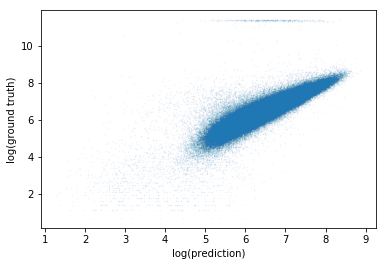

In [54]:
ypred = model.predict(dvalid)

plt.scatter(ypred, yv, s=0.1, alpha=0.1)
plt.xlabel('log(prediction)')
plt.ylabel('log(ground truth)')
plt.show()

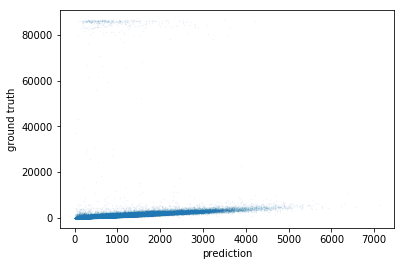

In [55]:
plt.scatter(np.exp(ypred), np.exp(yv), s=0.1, alpha=0.1)
plt.xlabel('prediction')
plt.ylabel('ground truth')
plt.show()

In [56]:
ytest = model.predict(dtest)

test['trip_duration'] = np.exp(ytest) - 1
test[['id', 'trip_duration']].to_csv('submission_v2.csv', index=False)